<a href="https://colab.research.google.com/github/ulfboge/deep-image-prior/blob/master/Deforestation_monitoring_use_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Installation**
This installs the SpaceSense SDK in your notebook

In [ ]:
!pip install spacesense

# **2. Import**
Imports the additional librairies needed in this use case

In [ ]:
from spacesense import Client, Sentinel2SearchResult
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import json
import pandas as pd
import os
import copy

We then import this function as it will be useful later on in the notebook to display some results

In [ ]:
def get_rgb(ds, brightness_factor=1):

    def norm(band):
        band_min, band_max = band.min(), band.max()
        return (band - band_min) / (band_max - band_min)
    
    var_names = ["S2_BLUE", "S2_GREEN", "S2_RED"]
    band_names = ["S2_B02", "S2_B03", "S2_B04"]

    for elem in var_names:
        if elem in ds.data_vars:
            if elem == "S2_BLUE":
                ds = ds.rename_vars({"S2_BLUE": "S2_B02"})
            elif elem == "S2_GREEN":
                ds = ds.rename_vars({"S2_GREEN": "S2_B03"})
            elif elem == "S2_RED":
                ds = ds.rename_vars({"S2_RED": "S2_B04"})

    blue = norm(ds.S2_B02) * brightness_factor
    green = norm(ds.S2_B03) * brightness_factor
    red = norm(ds.S2_B04) * brightness_factor
    rgb = np.dstack([red, green, blue])

    return rgb

# **3. Authentication**
Insert the API Key that you received by registering with SpaceSense. If you don't have one, you can register and [get one here](https://nut.sh/ell/forms/345883/X6p1Lz)

In [ ]:
api_key = "add_you_api_key_here"
os.environ["SS_API_KEY"] = api_key

# **4. Identify your Area Of Interest**
In the AOI variable you can add your Area Of Interest boundaries using a geojson format. If you want to build one, you can [do it here](https://geojson.io/#map=2/0/20)

In [ ]:
# Define the area of interest (AOI)
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -55.50512891703934,
              5.0521517900087645
            ],
            [
              -55.50512891703934,
              4.972725062296433
            ],
            [
              -55.4314385516314,
              4.972725062296433
            ],
            [
              -55.4314385516314,
              5.0521517900087645
            ],
            [
              -55.50512891703934,
              5.0521517900087645
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

# Get an instance of the SpaceSense Client object
client = Client(id="deforestation monitoring example")

# Enable to save data in local files
client.enable_local_output()

# **5. Search available images**
First add the Time range Of Interest (TOI) for your study.
Below the SDK will search Sentinel 2 images available for the AOI and TOI specified above, and then display all the results in a list

In [ ]:
# Define the time range of interest (TOI)
start_date = "2019-06-10"
end_date = "2021-12-31"
# Call the S2 search function, passing the AOI, and TOI
deforestation_search = client.s2_search(aoi=aoi, start_date=start_date, end_date=end_date, query_filters={"valid_pixel_percentage": {">=": 90}})
# Visualize the Pandas dataframe with the results
deforestation_search.dataframe

,id,date,tile,valid_pixel_percentage,platform,relative_orbit_number,product_id,datetime,swath_coverage_percentage,no_data,cloud_shadows,vegetation,not_vegetated,water,cloud_medium_probability,cloud_high_probability,thin_cirrus,snow
20,S2A_21NXF_20190619_0_L2A,2019-06-19,21NXF,99.67,sentinel-2a,110,S2A_MSIL2A_20190619T141051_N0212_R110_T21NXF_2...,2019-06-19T14:11:19Z,100.0,0.0,0.01,94.39,4.32,0.05,0.25,0.07,0.00,0.0
19,S2B_21NXF_20190823_0_L2A,2019-08-23,21NXF,96.89,sentinel-2b,110,S2B_MSIL2A_20190823T141049_N0213_R110_T21NXF_2...,2019-08-23T14:11:20Z,100.0,0.0,0.44,89.11,5.95,0.02,1.00,1.67,0.00,0.0
18,S2A_21NXF_20190828_0_L2A,2019-08-28,21NXF,91.83,sentinel-2a,110,S2A_MSIL2A_20190828T141051_N0213_R110_T21NXF_2...,2019-08-28T14:11:17Z,100.0,0.0,0.58,81.80,7.01,0.00,2.23,5.36,0.00,0.0
17,S2B_21NXF_20190902_0_L2A,2019-09-02,21NXF,99.26,sentinel-2b,110,S2B_MSIL2A_20190902T141049_N0213_R110_T21NXF_2...,2019-09-02T14:11:18Z,100.0,0.0,0.04,92.71,5.48,0.01,0.37,0.33,0.00,0.0
16,S2B_21NXF_20190912_0_L2A,2019-09-12,21NXF,99.88,sentinel-2b,110,S2B_MSIL2A_20190912T141049_N0213_R110_T21NXF_2...,2019-09-12T14:11:16Z,100.0,0.0,0.00,93.20,5.90,0.01,0.08,0.04,0.00,0.0
15,S2B_21NXF_20190922_0_L2A,2019-09-22,21NXF,98.74,sentinel-2b,110,S2B_MSIL2A_20190922T141049_N0213_R110_T21NXF_2...,2019-09-22T14:11:15Z,100.0,0.0,0.09,90.92,6.52,0.01,0.55,0.62,0.00,0.0
14,S2A_21NXF_20191007_0_L2A,2019-10-07,21NXF,93.67,sentinel-2a,110,S2A_MSIL2A_20191007T141051_N0213_R110_T21NXF_2...,2019-10-07T14:11:18Z,100.0,0.0,0.70,84.69,6.64,0.02,1.77,3.86,0.00,0.0
13,S2B_21NXF_20191012_0_L2A,2019-10-12,21NXF,90.20,sentinel-2b,110,S2B_MSIL2A_20191012T141049_N0213_R110_T21NXF_2...,2019-10-12T14:11:16Z,100.0,0.0,1.56,78.14,8.42,0.02,3.16,5.08,0.00,0.0
12,S2B_21NXF_20191022_0_L2A,2019-10-22,21NXF,99.85,sentinel-2b,110,S2B_MSIL2A_20191022T141049_N0213_R110_T21NXF_2...,2019-10-22T14:11:16Z,100.0,0.0,0.00,92.97,6.10,0.02,0.11,0.04,0.00,0.0
11,S2A_21NXF_20191106_0_L2A,2019-11-06,21NXF,93.44,sentinel-2a,110,S2A_MSIL2A_20191106T141051_N0213_R110_T21NXF_2...,2019-11-06T14:11:18Z,100.0,0.0,1.70,83.12,7.40,0.02,1.79,3.07,0.00,0.0


We see on the dataframe above that we have 21 images available for the time period we are looking for. 
In this example, we create a new Sentinel2SearchResult object only composed of images coming from the Sentinel 2a satellite. This is to have the same exact optical calibration in the images that we compare. It improves accuracy

In [ ]:
deforestation_search_s2a = copy.deepcopy(deforestation_search)
deforestation_search_s2a.dataframe = deforestation_search_s2a.dataframe[deforestation_search_s2a.dataframe["platform"] == "sentinel-2a"]

We define the bands we want to download. This saves processing time and cost, giving us only what we need. 
As you see, you can also download pre-computed vegetation indices. The full list is available on the documentation

In [ ]:
deforestation_search_s2a.output_bands = ["B02", "B03", "B04", "SCL", "NDVI"]

# **6. Downloading the images**
Through the fuse function we are able to download all images we selected into a single object

In [ ]:
# Call the core fusion function, passing our filtered S2 result
fusion = client.fuse([deforestation_search_s2a])
# Visualize the Pandas dataframe with the results
fusion.dataset

<xarray.Dataset>
Dimensions:  (time: 11, y: 881, x: 816)
Coordinates:
  * time     (time) datetime64[ns] 2019-06-19 2019-08-28 ... 2021-11-05
  * y        (y) float32 5.052 5.052 5.052 5.052 ... 4.973 4.973 4.973 4.973
  * x        (x) float32 -55.51 -55.5 -55.5 -55.5 ... -55.43 -55.43 -55.43
Data variables:
    S2_B02   (time, y, x) float32 0.0195 0.0203 0.0191 ... 0.0331 0.0337 0.0292
    S2_B03   (time, y, x) float32 0.0332 0.0375 0.0378 ... 0.0604 0.07 0.0576
    S2_B04   (time, y, x) float32 0.0166 0.0219 0.0204 ... 0.0281 0.032 0.0275
    S2_SCL   (time, y, x) float32 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0 4.0
    S2_NDVI  (time, y, x) float32 0.8697 0.8489 0.8476 ... 0.8696 0.8694 0.8799
    S2_LAI   (time, y, x) float32 2.833 3.113 2.909 2.831 ... 4.461 5.007 4.746
    S2_NDWI  (time, y, x) float32 0.1574 0.2279 0.1897 ... 0.3278 0.3552 0.3278
Attributes:
    transform:        [ 9.03919431e-05  0.00000000e+00 -5.55051302e+01  0.000...
    crs:              +init=epsg:4326
    res:              [9.03919431e-05 9.02273438e-05]
    descriptions:     ['B02', 'B03', 'B04', 'SCL', 'NDVI', 'LAI', 'NDWI']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-55.50513019   5.05218535]

Below we display the images we have to select the best ones to compare

In [ ]:
rgb = fusion.plot_rgb(all_dates = True, brightness_factor = 3)


Utdatan från den här cellen är för stor för att visas när du är utloggad.


# **7. Detect the deforestation**


Now let's select the images which have the least clouds, to be able to do a proper comparaison




In [ ]:
img_before = fusion.dataset.isel(time=0) #2019-06-19
img_after = fusion.dataset.isel(time=5) #2020-08-22

Here we compare the two images by looking at their NDVI value, which highlights the differences between the two images

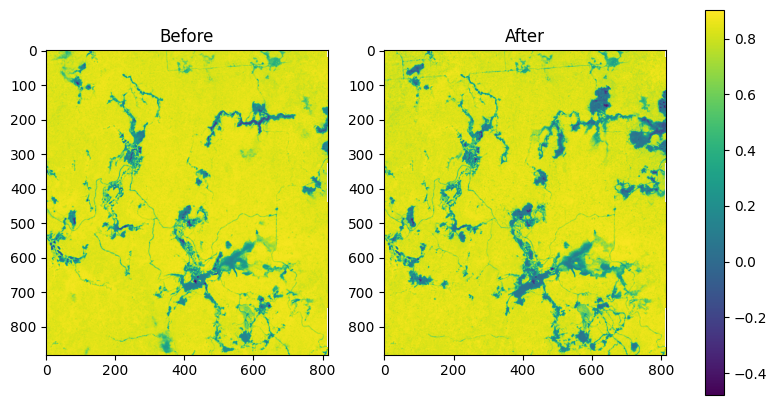

In [ ]:
data_before = img_before.S2_NDVI
data_after = img_after.S2_NDVI

# Create the subplots with a larger figure size
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Display the images with titles
img_before = axes[0].imshow(data_before)
axes[0].set_title('Before')
img_after = axes[1].imshow(data_after)
axes[1].set_title('After')

# Add the color bar to the second plot with the same normalization
cbar = fig.colorbar(img_after, ax=axes.ravel().tolist(), norm=img_after.norm)

# Show the plot
plt.show()

We can now use two methods to highlight the differences between these two images:


1.   Display the delta between the two images' NDVI
2.   Create a mask that flags all delta values above a certain threshold. In this example the threshold is a delta of 0.4. This is rather arbitrary, and should be experimented on, and adapted for the climate and type of forest you are looking at



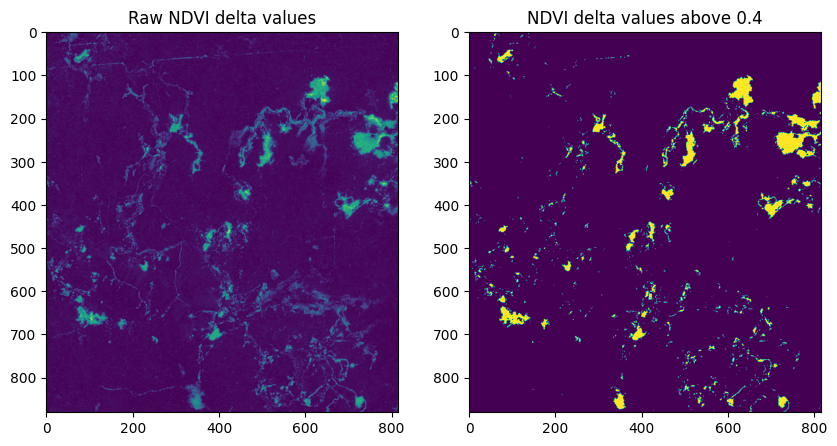

In [ ]:
# Create the xarray object which has the delta NDVI value between the two dates
data_delta = abs(data_after - data_before)

# Create the xarray object with the binary mask only keeping the pixels with 0.4 delta value
delta_mask = xr.DataArray(data_delta > 0.4, dims=('y', 'x'))

# Create the subplots with a larger figure size
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Display the images with titles
img_before = axes[0].imshow(data_delta)
axes[0].set_title('Raw NDVI delta values')
img_after = axes[1].imshow(delta_mask)
axes[1].set_title('NDVI delta values > 0.4')

# Show the plot
plt.show()

Here is what it looks like when we want to display the two dates next to the delta mask, and and overlay of the mask with the original image.

As you can see, there are a few clouds which have been categorised as deforestation. We'll remedy to this issue in the next section

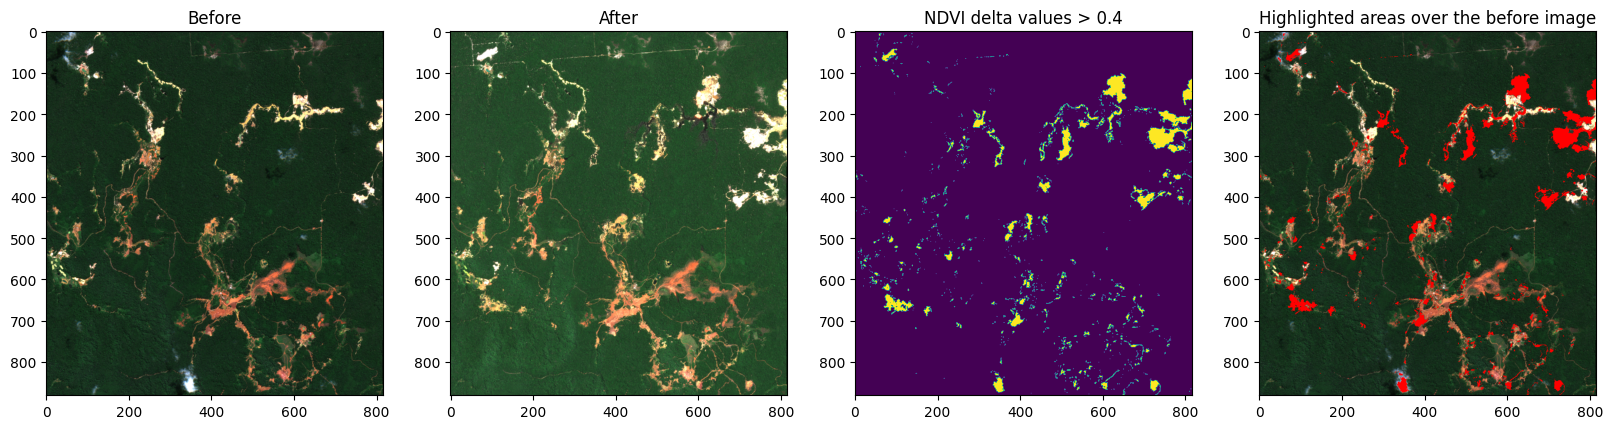

In [ ]:
#Create a mask show the highlighted areas directly on the RGB image
img_highlighted = get_rgb(img_before, brightness_factor=3)
img_highlighted[delta_mask] = [1, 0, 0] # red color

# Create the subplots with a larger figure size
fig, axes = plt.subplots(ncols=4, figsize=(20, 12))

# Display the images with titles
img_before = axes[0].imshow(get_rgb(img_before, brightness_factor=3))
axes[0].set_title('Before')
img_after = axes[1].imshow(get_rgb(img_after, brightness_factor=3))
axes[1].set_title('After')
img_after = axes[2].imshow(delta_mask)
axes[2].set_title('NDVI delta values > 0.4')
img_after = axes[3].imshow(img_highlighted)
axes[3].set_title('Highlighted areas over the before image')

# Show the plot
plt.show()

And below we can try to build an approximation of the deforested surface in hectares, using the fact that a pixel on Sentinel 2 is about 10x10 meters

In [ ]:
deforested_pixels = np.count_nonzero(delta_mask)
deforested_surface = deforested_pixels / 100
date_before = fusiona.dataset.isel(time=0)["time"].values
date_after = fusiona.dataset.isel(time=5)["time"].values

print(f"In this image there is an estimated {deforested_surface} hectares which were deforested between the {date_before} and {date_after}")


In this image there is an estimated 279.86 hectares which were deforested between the 2019-06-19T00:00:00.000000000 and 2020-08-22T00:00:00.000000000


# **8. Dealing with cloudy images**
We are going to reproduce the same example as above, but now we will take an image which have a few clouds on it, and see how to deal with it

In [ ]:
img_after = fusion.dataset.isel(time=7) #2019-06-19
img_before = fusion.dataset.isel(time=0) #2021-09-06


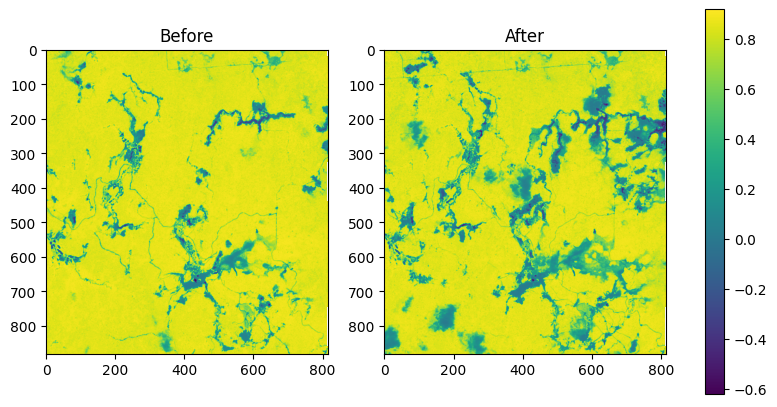

In [ ]:
data_before = img_before.S2_NDVI
data_after = img_after.S2_NDVI

# Create the subplots with a larger figure size
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Display the images with titles
img_before = axes[0].imshow(data_before)
axes[0].set_title('Before')
img_after = axes[1].imshow(data_after)
axes[1].set_title('After')

# Add the color bar to the second plot with the same normalization
cbar = fig.colorbar(img_after, ax=axes.ravel().tolist(), norm=img_after.norm)

# Show the plot
plt.show()

Here comes the main difference. The Copernicus data offers an SCL band, which classifies each type of pixel in differents categories. Some of these are clouds or clouds shadow. This is what we will use to remove the clouds. Please keep in mind that this is not a perfect solution, but is a good way to get started

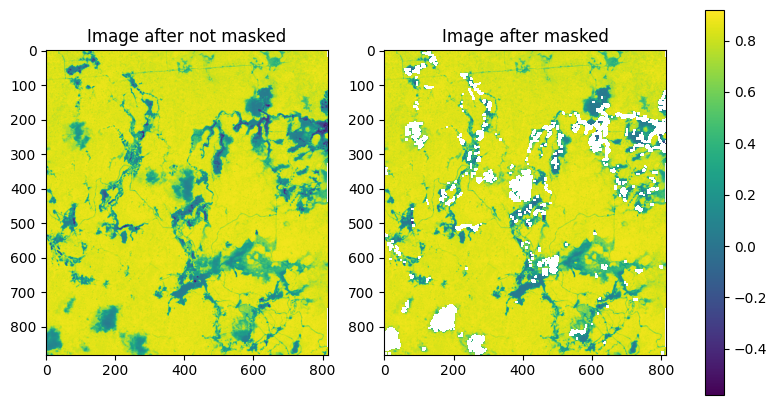

In [ ]:
#Here we select the SCL band in our satellite image, which provides information on which category each pixel falls into, based on the Copernicus classification
img_after_SCL_band = img_after.S2_SCL
classes_to_keep = [1,2,4,5,6]

#We create a cloud mask on the pixels that are cloudy
cloud_mask = xr.DataArray(np.in1d(img_after_SCL_band, classes_to_keep).reshape(img_after_SCL_band.shape),dims=img_after_SCL_band.dims, coords=img_after_SCL_band.coords)

data_after_masked = data_after.where(cloud_mask)

# Create the subplots with a larger figure size
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Display the images with titles
img_before = axes[0].imshow(data_after)
axes[0].set_title('Image after not masked')
img_after = axes[1].imshow(data_after_masked)
axes[1].set_title('Image after masked')


# Add the color bar to the second plot with the same normalization
cbar = fig.colorbar(img_after, ax=axes.ravel().tolist(), norm=img_after.norm)

# Show the plot
plt.show()


Below we recreate the delta mask ,while taking into account the clouded zones

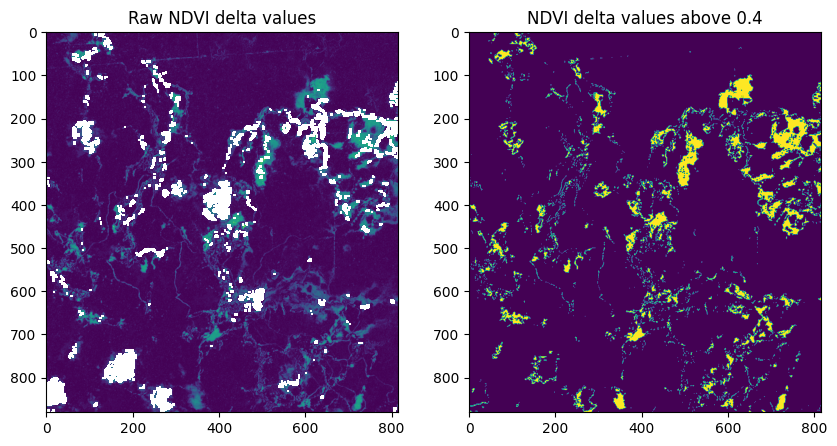

In [ ]:
data_delta = abs(data_after_masked - data_before)

delta_mask = xr.DataArray(data_delta > 0.4, dims=('y', 'x'))

# Create the subplots with a larger figure size
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

# Display the images with titles
img_before = axes[0].imshow(data_delta)
axes[0].set_title('Raw NDVI delta values')
img_after = axes[1].imshow(delta_mask)
axes[1].set_title('NDVI delta values above 0.4')

# Show the plot
plt.show()

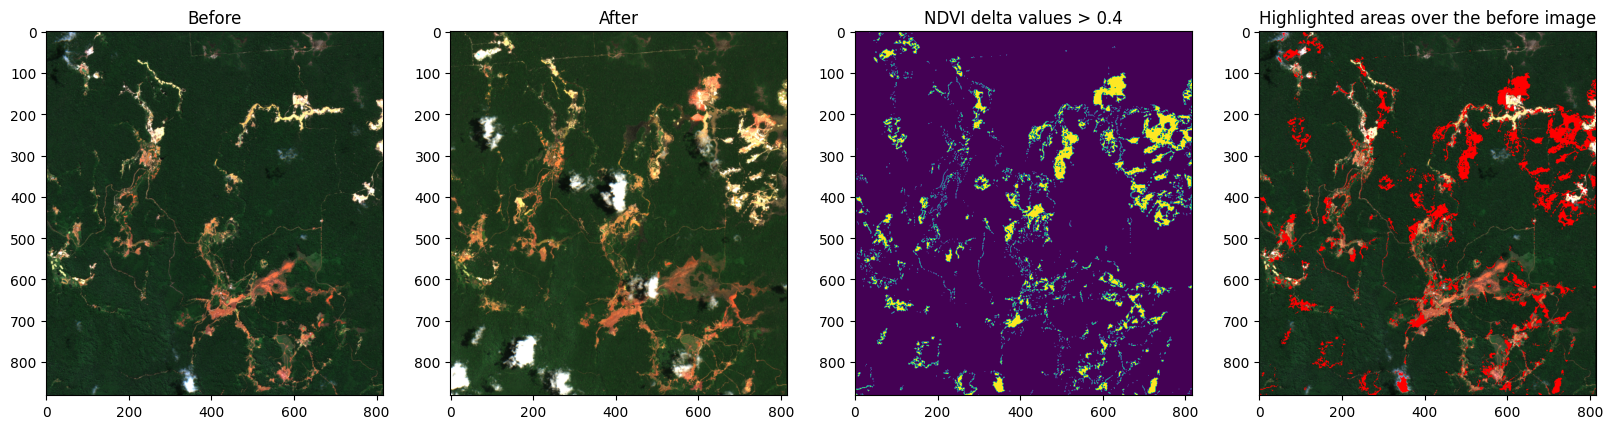

In [ ]:
#Create a mask show the highlighted areas directly on the RGB image
img_highlighted = get_rgb(img_before, brightness_factor=3)
img_highlighted[delta_mask] = [1, 0, 0] # red color

# Create the subplots with a larger figure size
fig, axes = plt.subplots(ncols=4, figsize=(20, 12))

# Display the images with titles
img_before = axes[0].imshow(get_rgb(img_before, brightness_factor=3))
axes[0].set_title('Before')
img_after = axes[1].imshow(get_rgb(img_after, brightness_factor=3))
axes[1].set_title('After')
img_after = axes[2].imshow(delta_mask)
axes[2].set_title('NDVI delta values > 0.4')
img_after = axes[3].imshow(img_highlighted)
axes[3].set_title('Highlighted areas over the before image')

# Show the plot
plt.show()

In [ ]:
deforested_pixels = np.count_nonzero(delta_mask)
deforested_surface = deforested_pixels / 100
date_before = fusion.dataset.isel(time=0)["time"].values
date_after = fusion.dataset.isel(time=7)["time"].values

print(f"In this image there is an estimated {deforested_surface} hectares which were deforested between the {date_before} and {date_after}")


In this image there is an estimated 534.54 hectares which were deforested between the 2019-06-19T00:00:00.000000000 and 2021-09-06T00:00:00.000000000
